In [2]:
from PIL import Image
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm  # pour viisualiser le progrés

In [3]:
# Chemins des dossiers
parasitized_path = r'C:/Users/SOS2023/OneDrive/Desktop/PYTHON-2024/malaria_hematie_dataset/malaria_hematie_dataset/parasitized'
uninfected_path = r'C:/Users/SOS2023/OneDrive/Desktop/PYTHON-2024/malaria_hematie_dataset/malaria_hematie_dataset/uninfected'

In [4]:
# Preprocesser les images
def preprocess_images(folder_path, target_size=(128, 128)):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(folder_path.split('/')[-1])  # Extract label from folder name
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    return np.array(images), labels

In [5]:
# les parasitized 
parasitized_images, parasitized_labels = preprocess_images(parasitized_path)

# les uninfected 
uninfected_images, uninfected_labels = preprocess_images(uninfected_path)

100%|██████████| 13779/13779 [00:25<00:00, 549.39it/s]


In [6]:
# shape des images
print("Parasitized Image Shapes:", set(img.shape for img in parasitized_images))
print("Uninfected Image Shapes:", set(img.shape for img in uninfected_images))

Parasitized Image Shapes: {(128, 128, 3)}
Uninfected Image Shapes: {(128, 128, 3)}


In [7]:
# Concatenater les données Preprocesser
images = np.concatenate((parasitized_images, uninfected_images))
labels = parasitized_labels + uninfected_labels

In [8]:
# Normalisation 
images_normalized = images / 255.0

In [9]:
# Encodage des labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [10]:
# les shapes et le nombre des labels
print("Shape of Images:", images.shape)
print("Length of Labels:", len(labels_encoded))

Shape of Images: (27558, 128, 128, 3)
Length of Labels: 27558


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

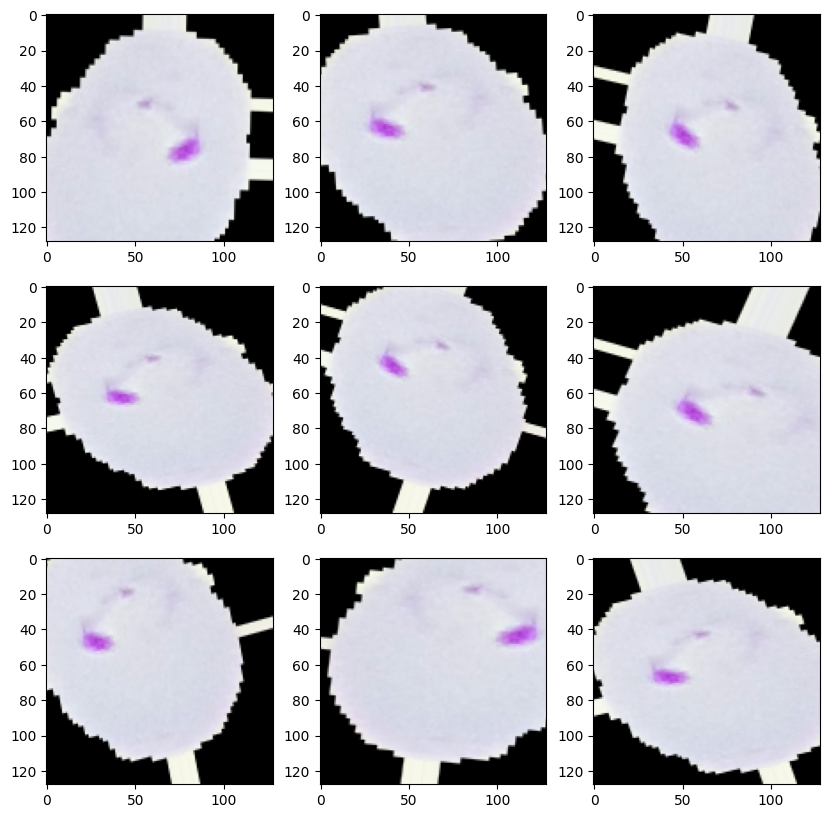

In [15]:
import matplotlib.pyplot as plt


img = images_normalized[0]
img = img.reshape((1,) + img.shape)

plt.figure(figsize=(10, 10))
i = 0
for batch in datagen.flow(img, batch_size=1):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0])
    i += 1
    if i % 9 == 0:
        break
plt.show()

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

img_height, img_width, channels = images.shape[1:]

num_classes = len(np.unique(labels_encoded))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

c:\Users\SOS2023\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
from keras.applications import VGG16
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 159s 3us/step


In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=2, monitor='val_loss')
]

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(images_normalized, labels_encoded, epochs=10, validation_split=0.2, callbacks=callbacks)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 207s 294ms/step - accuracy: 0.6988 - loss: 0.6134 - val_accuracy: 0.9556 - val_loss: 0.1930 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 188s 273ms/step - accuracy: 0.9278 - loss: 0.2373 - val_accuracy: 0.8752 - val_loss: 0.2795 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 182s 264ms/step - accuracy: 0.9386 - loss: 0.1838 - val_accuracy: 0.9323 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 191s 277ms/step - accuracy: 0.9463 - loss: 0.1483 - val_accuracy: 0.8360 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9527 - loss: 0.1350

In [1]:
model.save_weights('model_weights.weights.h5')


NameError: name 'model' is not defined

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels_encoded, test_size=0.2, random_state=42)

NameError: name 'images_normalized' is not defined

In [ ]:
#  prédictions sur le jeu de test
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de Confusion :\n", cm)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# les différentes métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# les métriques
print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("F1-Score :", f1)

# le rapport de classification
print("Rapport de Classification :\n", classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# les scores de probabilité pour les classes positives
y_prob = model.predict(X_test)

if y_prob.shape[1] > 1:
    y_prob = y_prob[:, 1]
else:
    y_prob = y_prob.ravel()

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# AUC
auc = roc_auc_score(y_test, y_prob)

# Affichage
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Courbe ROC')
plt.legend()
plt.show()

print("AUC :", auc)